# ACT Framework Demo
## Agentic Classification Tree

This notebook demonstrates how to use the ACT framework for LLM-powered decision tree classification.

### What is ACT?
ACT is a novel machine learning framework that uses Large Language Models (LLMs) to build interpretable decision trees. Instead of traditional numerical splits, ACT learns natural language questions at each node that best separate the data, through prompt optimization based on TextGrad.

### Notebook Overview:
1. **Setup**: Chose model and how to serve it (OpenAI API key, vllm, ollama etc.)
2. **Load Dataset**: Load training and test data
3. **Train Model**: Build and optimize the decision tree
4. **Evaluate**: Test model performance
5. **Visualize**: Plot the learned decision tree

## Step 0: Install Dependencies

Make sure to set up the `act` conda environment and select the corresponding kernel in Jupyter, as described in the README.

In [8]:
# Setup local TextGrad path
# Necessary because some files to load the data had to be modified

import sys
import os
local_textgrad_path = '../textgrad'

if os.path.exists(local_textgrad_path):
    sys.path.insert(0, os.path.dirname(local_textgrad_path))
    print(f"✅ Using local TextGrad from: {local_textgrad_path}")
else:
    print("⚠️ Local TextGrad not found, will use installed version")

import textgrad as tg

✅ Using local TextGrad from: ../textgrad


## Step 1: Setup LLM

Configure your OpenAI or Azure API key in the .env file as described in the README.

In [9]:
import src.demo_helper as hd
from dotenv import load_dotenv

# Optional: Display quick start guide
# hd.print_quick_start()

# Setup engine, loading API keys etc. from .env file
load_dotenv(override=True)
llm_engine = hd.setup_engine(model_string="azure-gpt-4.1-nano")

# Test LLM engine
test_response = llm_engine("Say 'Working!' if you receive this.")
print(f"✅ Engine test: {test_response}")

[INFO] Initialized engine: azure-gpt-4.1-nano
✅ Engine test: Working!


## Step 2: Load Dataset

Load a classification dataset. Currently supported tasks are DIAGNO, SPAM and JAILBREAK

In [12]:
import src.demo_helper as hd

TASK = "DIAGNO" # Change task name here. Currently supported tasks are DIAGNO, SPAM and JAILBREAK

# Load the dataset and the function to extract answers for evaluation
train_set, val_set, test_set, eval_fn = hd.load_dataset(
    task_name=TASK, 
    llm_engine=llm_engine
)

# Display sample data
print("\n" + "="*60)
print("SAMPLE DATA INFORMATION & EXAMPLES")
print("="*60)

for i, (text, label) in enumerate(train_set[:3]):
    print(f"\nExample {i+1}:")
    print(f"Input -> {text[:200]}...")
    print(f"Label: {label}")

# Print label distribution for test set
hd.print_label_distribution(test_set, "Test Set")

[INFO] Loading dataset: DIAGNO
[INFO] Dataset loaded - Train: 600, Val: 100, Test: 600

SAMPLE DATA INFORMATION & EXAMPLES

Example 1:
Input -> Symptoms: I am an 83-year-old male with a persistent cough, vomiting after coughing, and wheezing....
Label: no

Example 2:
Input -> Symptoms: At 65 years old and male, I have an itchy nose, shortness of breath, cough with blood, and cough presence....
Label: no

Example 3:
Input -> Symptoms: My main symptom is a runny nose, along with symptoms of itchy nose or throat, eye itching, and cough presence....
Label: no

TEST SET - LABEL DISTRIBUTION
Total samples: 600

     no:  300 ( 50.0%) █████████████████████████
    yes:  300 ( 50.0%) █████████████████████████



## Step 3: Train ACART Model

Train the decision tree by optimizing natural language questions at each node. Depending on the task, LLM provider, the concurrency possible and ACT hyperparameter settings combination, this cell needs 5min - 8h to execute.

**Parameters:**
- `max_depth`: Maximum depth of the tree (deeper = more complex)
- `max_steps_per_node`: Number of optimization steps per node (more = better questions)
- `num_threads`: Parallel threads for faster training
- `max_logical_ops`: Maximum 'and'/'or' operators in questions
- `max_examples_per_group`: Max number of examples per category that are used to generate semantic feedback (more = more information and longer prompts during optimization)
- `keyword`: Additional information to hint LLM for what to look for in the text samples (default is 'characteristic')
- `data_type`: Additional information about the data samples to hint the LLM in the right direction (default is 'a text')
- `min_gini`: Gini stopping criterion: if a node reaches a Gini impurity lower than min_gini, stop splitting at this node (default is 0.05)

In [7]:
# Optional: Delete cache to avoid re-using stored results
# If cache is not removed, TextGrad re-uses cached results as default
# For more information visit: https://github.com/zou-group/textgrad/issues/107

from pathlib import Path
import shutil

cache_dir = Path("~/.cache/textgrad").expanduser()
# optional safety check to avoid accidents
if cache_dir.is_dir() and str(cache_dir).startswith(str(Path.home())):
    shutil.rmtree(cache_dir, ignore_errors=True)
print(f"Removed: {cache_dir}")

Removed: /Users/b715wt/.cache/textgrad


In [ ]:
from src.demo_helper import train_model

# Train the model
model = train_model(
    train_set=train_set,
    llm_engine=llm_engine,
    max_depth=3,                # Maximum depth of the tree (deeper trees are more complex)
    max_steps_per_node=10,      # Number of optimization steps to refine each question
    num_threads=16,             # Number of parallel threads (adjust based on your machine)
    max_logical_ops=2,          # Maximum number of 'and'/'or' operators allowed in questions (keeps questions simple)
    max_examples_per_group=50,  # Maximum number of examples shown per group during each optimization stepWiederholen
    keyword="symptom",          # Additional information to hint LLM for what to look for in the text samples (default is 'characteristic')
    data_type="a patient's symptom description",       # Additional information about the data samples to hint the LLM in the right direction (default is 'a text')
    min_gini=0.05,              # Gini stopping criterion: if a node reaches a Gini impurity lower than min_gini, stop splitting at this node
    verbose=True
)

print("\n✅ Model training complete!")

# ⚠️ Note: Due to multithreading, print outputs during training (after the root node) may appear out of order.

[INFO] Using local TextGrad from: /Users/b715wt/ACT/ACT_Demo/demo_notebook/../src/../textgrad
[INFO] Training ACT model with max_depth=3, max_steps_per_node=10
[INFO] Created CARTAgent model for SYSTEM PROMPT.
[INFO] fit_cart_llm: path=root, node.depth=0, max_depth=3, max_n=50
[NOW] prompt_var.value =  Based on the provided context, does this example belong to the positive class? (yes/no)
[STEP 1/10] Path: root
[INFO] Prompt: Based on the provided context, does this example belong to the positive class? (yes/no)
[INFO] For path: root at step 1/10 -> Weighted Gini impurity: 0.49730888907577164
-----------------------TextualGradientDescent------------------------
Does the example include either cough or weight loss? (yes/no)
[STEP 2/10] Path: root
[INFO] Prompt: Does the example include either cough or weight loss? (yes/no)
[INFO] For path: root at step 2/10 -> Weighted Gini impurity: 0.4473129545925267
-----------------------TextualGradientDescent------------------------
Does the exampl

## Step 4: Evaluate Model

Test the trained model on both training and test sets to assess performance.

In [ ]:
from src.demo_helper import evaluate_model

# Evaluate on training set
print("Evaluating on TRAINING set:")
train_accuracy = evaluate_model(
    dataset=train_set,
    model=model,
    eval_fn=eval_fn,
    num_threads=16,             # Number of parallel threads (adjust based on your setup)
    keyword="symptom",          # Should be the same as during training
    data_type="a patient's symptom description",  # Should be the same as during training
    # max_samples=300,          # Maximum number of samples to evaluate (default: None evaluates entire dataset)
    verbose=True
)

# Evaluate on test set
print("\nEvaluating on TEST set:")
test_accuracy = evaluate_model(
    dataset=test_set,
    model=model,
    eval_fn=eval_fn,
    num_threads=16,             # Number of parallel threads (adjust based on your setup)
    keyword="symptom",          # Should be the same as during training
    data_type="a patient's symptom description",  # Should be the same as during training
    # max_samples=300,          # Maximum number of samples to evaluate (default: None evaluates entire dataset)
    verbose=True
)

# Display results
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Training Accuracy:  {train_accuracy:.2%}")
print(f"Test Accuracy:      {test_accuracy:.2%}")
print(f"Generalization Gap: {abs(train_accuracy - test_accuracy):.2%}")

[INFO] Using local TextGrad from: /Users/b715wt/ACT/ACT_Demo/demo_notebook/../src/../textgrad
Evaluating on TRAINING set:
[INFO] Evaluating model on 600 samples...


Accuracy: 0.6883333333333334: 100%|██████████| 600/600 [01:10<00:00,  8.48it/s]


[INFO] Accuracy: 0.6883 (68.83%)

Evaluating on TEST set:
[INFO] Evaluating model on 600 samples...


Accuracy: 0.6716666666666666: 100%|██████████| 600/600 [01:12<00:00,  8.33it/s]

[INFO] Accuracy: 0.6717 (67.17%)

FINAL RESULTS
Training Accuracy:  68.83%
Test Accuracy:      67.17%
Generalization Gap: 1.67%


## Step 5: Visualize Decision Tree

Generate a visual representation of the learned decision tree showing:
- Internal nodes: Natural language questions
- Leaf nodes: Final predictions

[INFO] Generating simplified tree visualization with trimming...
[TRIM] Converting node with question to leaf (label: yes)
[TRIM] Converting node with question to leaf (label: yes)
[TRIM] Converting node with question to leaf (label: yes)
[TRIM] Converting node with question to leaf (label: no)


/Users/b715wt/ACT/ACT_Demo/demo_notebook/../src/demo_helper.py:432: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Tree saved to ../output/act_tree.png


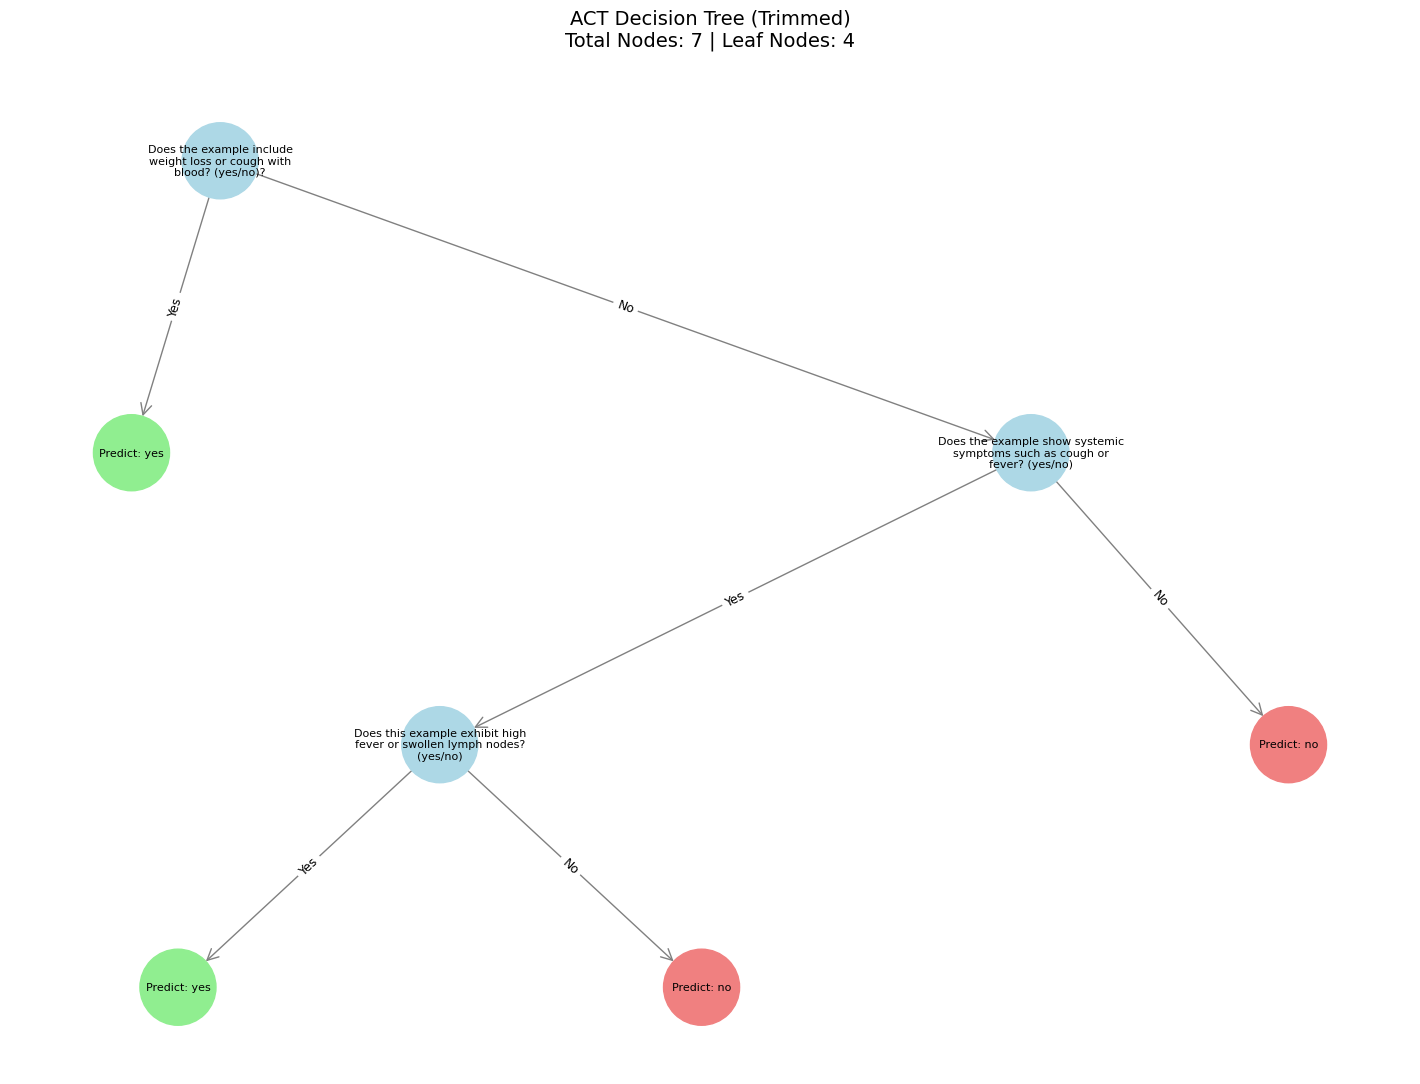

✅ Tree visualization complete! (Trimmed to 7 nodes)

📊 Tree visualization complete!
💾 Saved to: output/act_tree.png


In [ ]:
from src.demo_helper import plot_tree

# Visualize the tree
graph = plot_tree(
    model=model,
    train_set=train_set,
    llm_engine=llm_engine,
    num_threads=16, # Adjust based on your setup
    save_path="../output/act_diagno_tree.png"  # Save to file
)

print("\n📊 Tree visualization complete!")
print("💾 Saved to: output/act_diagno_tree.png")

## Summary

### What We Demonstrated:
1. ✅ Loaded a classification dataset
2. ✅ Trained an ACT model with LLM-optimized questions
3. ✅ Evaluated performance on train and test sets
4. ✅ Visualized the interpretable decision tree

### Key Advantages of ACART:
- **Interpretable**: Clear and easy natural language questions at each node
- **Flexible**: Works with any text classification task
- **Powerful**: Leverages LLM reasoning capabilities
- **Transparent**: Visual tree shows decision logic

---

**Questions or Issues?**
- Check that all dependencies are installed
- Verify your OpenAI API key is valid
- Ensure you have sufficient API credits
- For visualization errors, install: `pip install pygraphviz`